In [154]:
from mesa import Model, Agent
from mesa.time import SimultaneousActivation
from mesa.space import MultiGrid


from mesa.datacollection import DataCollector


import numpy as np
import pandas as pd

import random


def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))
    for cell in model.grid.coord_iter():
      cell_content, (x, y) = cell
      for obj in cell_content:
        if isinstance(obj, Car):
          grid[x][y] = 4
        elif isinstance(obj, TrafficLight):
          grid[x][y] = obj.state + 1
        elif isinstance(obj, lightsController):
            grid[x][y] = 5
    return grid

class Cross(Model):
    # Agregar un metodo para que obtenga la informacion de los agentes (solamante de los carros y los semaforos)
    def __init__(self, width, height, tl):
        self.grid = MultiGrid(width, height, False)
        self.width = width
        self.height = height
        self.schedule = SimultaneousActivation(self)
        self.running = True
        self.trafic_lights = tl
        self.lights = []
        self.contador = 0
        self.origin = [(12,0) ,(13,0) ,(0,10),(0,11) ,(10,23),(11,23),(23,12),(23,13)]
        self.destination = [(12,23),(23,10),(10,0),(23,11),(0,13) ,(11,0) ,(0,12), (13,23)]
        self.middle = [(13, 10), (13, 10), (10, 10), (10, 10), (10, 13), (10, 13), (13, 13), (13,13)]
        self.next_dir = [(1,0), (1,0), (0, -1), (0,-1), (-1, 0), (-1, 0), (0, 1), (0,1)]
        self.directions = [(0,1),(0,1),(1,0),(1,0),(0,-1),(0,-1),(-1,0),(-1,0)]
        self.lightIndex = [0,0,1,1,2,2,3,3]

        tempx = [(12, 13),(0, 9), (10, 11), (14, 23)]
        tempy = [(0,9), (10, 11), (14, 23), (12, 13)]

        for test in tl:
            lista = []
            for i in range(tempx[self.contador][0], tempx[self.contador][1]+1):
                for j in range(tempy[self.contador][0], tempy[self.contador][1]+1):
                    #print(i,j)
                    lista.append((i,j))
            t = TrafficLight(self.contador, self, test, 0, lista)
            self.contador += 1
            self.grid.place_agent(t, (test[0], test[1]))
            self.schedule.add(t)
            self.lights.append(t)
        
        controller = lightsController(self.contador, self, (23,0), self.lights)
        self.contador += 1
        self.grid.place_agent(controller, (23,0))
        self.schedule.add(controller)

        # Quitar esta parte de crear los carros ya que se crearan en el step
        for i in range(len(self.origin)):
            car = Car(self.contador, self, self.origin[i], self.destination[i], self.directions[i], self.lights[self.lightIndex[i]], self.next_dir[i], self.middle[i])
            self.contador += 1
            self.grid.place_agent(car, self.origin[i])
            self.schedule.add(car)

        self.datacollector = DataCollector(
                model_reporters={"Grid": get_grid},  # A function to call
        )
            
    def step(self):
        cell = self.grid.get_cell_list_contents(self.origin[2])
        if len(cell) == 0:
            # aqui se agregan los metodos para agregar los carros (varia entre 3 opciones, 1 - Trafico Ligero, 2 - Trafico Medio, 3 - Trafico Pesado)
            ccar = Car(self.contador, self, self.origin[2], self.destination[2], self.directions[2], self.lights[self.lightIndex[2]], self.next_dir[2], self.middle[2])
            self.contador += 1
            self.grid.place_agent(ccar, self.origin[2])
            self.schedule.add(ccar)
        
        self.schedule.step()
        self.datacollector.collect(self)

class Car(Agent):
    def __init__(self, unique_id, model, pos, dest, dir, tl, next_dir, middle):
        super().__init__(unique_id, model)
        self.pos = pos
        self.next_pos = pos
        self.dest = dest
        self.dir = dir
        self.type = "Car"
        self.traffic_light = tl
        self.next_dir = next_dir
        self.middle = middle
        self.first = False
    
    def move(self):
        next = (self.pos[0] + self.dir[0], self.pos[1] + self.dir[1])
        if next[0] >= 0 and next[0] < self.model.width and next[1] >= 0 and next[1] < self.model.height:
            cellmates = self.model.grid.get_cell_list_contents(next)
            trigger = False
            for agent in cellmates:
                if isinstance(agent, Car):
                    trigger = True
            if not trigger:
                if next in self.traffic_light.area:
                    self.next_pos = next
                else:
                    if not self.first:
                        if self.traffic_light.state == 2:
                            self.next_pos = next
                            self.first = True
                    else:
                        self.next_pos = next
                    
    def step(self):
        if self.pos in self.traffic_light.area:
            if self.traffic_light.state == 2:
                self.move()
            else:
                self.move()
        else:
            self.move()

    def advance(self):
        if self.pos == self.dest:
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)
        elif self.pos != self.next_pos:
            if self.next_pos == self.middle:
                self.dir = self.next_dir
            self.model.grid.move_agent(self, self.next_pos)
            self.pos = self.next_pos
        
            
class TrafficLight(Agent):
    def __init__(self, unique_id, model, pos, state, area):
        # state: 0 = red, 1 = yellow, 2 = green
        super().__init__(unique_id, model)
        self.pos = pos
        self.state = state
        self.next_state = state
        self.type = "TrafficLight"
        self.area = area
        self.num_carros = 0
        self.contador = 0
    
    def step(self):
        self.num_carros = 0
        for cord in self.area:
            cellmates = self.model.grid.get_cell_list_contents(cord)
            for agent in cellmates:
                if isinstance(agent, Car):
                    self.num_carros += 1

    def advance(self):
        if self.state != self.next_state:
            self.state = self.next_state

class lightsController(Agent):
    # 0 rojo
    # 1 amarillo
    # 2 verde
    # [0]izq ; [2] der ; [1] top ; [3] down
    def __init__(self, unique_id, model, pos, tl):
        super().__init__(unique_id, model)
        self.pos = pos
        self.traffic_lights = tl
        self.type = "lightsController"
        self.contador = 0

    def step(self):
        all_have_cars = all(tls.num_carros > 0 for tls in self.traffic_lights)

        for tls in self.traffic_lights:
            if all_have_cars:
                self.traffic_lights[0].next_state = 2
            else:
                if tls.num_carros > 0:
                    tls.next_state = 2  # Set to green if cars are waiting
                    tls.contador = 0
                else:
                    tls.next_state = 1
                    tls.contador += 1
                    if tls.contador > 5:
                        tls.next_state = 0
                
        if self.traffic_lights[0].next_state == 2:
            self.traffic_lights[2].next_state = 2
        if self.traffic_lights[2].next_state == 2:
            self.traffic_lights[0].next_state = 2

        if self.traffic_lights[1].next_state == 2:
            self.traffic_lights[3].next_state = 2
        if self.traffic_lights[3].next_state == 2:
            self.traffic_lights[1].next_state = 2


        if self.traffic_lights[0].next_state == 1:
            self.traffic_lights[2].next_state = 1
            self.traffic_lights[1].next_state = 0
            self.traffic_lights[3].next_state = 0
        if self.traffic_lights[2].next_state == 1:
            self.traffic_lights[0].next_state = 1
            self.traffic_lights[1].next_state = 0
            self.traffic_lights[3].next_state = 0

        if self.traffic_lights[1].next_state == 1:
            self.traffic_lights[3].next_state = 1
            self.traffic_lights[0].next_state = 0
            self.traffic_lights[2].next_state = 0
        if self.traffic_lights[3].next_state == 1:
            self.traffic_lights[1].next_state = 1
            self.traffic_lights[0].next_state = 0
            self.traffic_lights[2].next_state = 0


    
    def advance(self):
       self.contador += 1

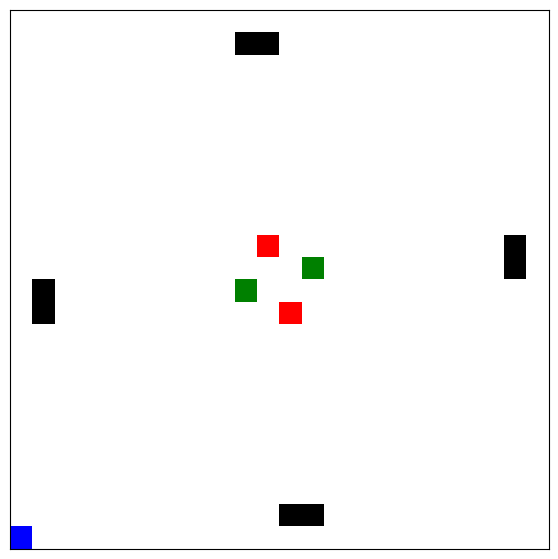

In [155]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

    
if __name__ == "__main__":
    # Modificar todo el main (crear un servidor y que cada GET sea un step)
    widht = 24
    height = 24  
    tiempo = 0.5

    cmp = matplotlib.colors.ListedColormap(['white','red', 'yellow', 'green', 'black','blue'])

    tl = [(12,10),(10,11),(11,13),(13,12)]
    model = Cross(widht, height, tl)
    
    contador = 0
    while (contador < 200):
        model.step()
        contador += 1
    
    all_grid = model.datacollector.get_model_vars_dataframe()

    fig, axs = plt.subplots(figsize=(7,7))
    axs.set_xticks([])
    axs.set_yticks([])
    # show the grid with color
    patch = plt.imshow(all_grid.iloc[0][0], cmap=cmp)

    #patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary)

    def animate(i):
        patch.set_data(all_grid.iloc[i][0])

    anim = animation.FuncAnimation(fig, animate, frames=len(all_grid))

    # save animation using pillow writer

    writergif = animation.PillowWriter(fps=5)
    
    anim.save('animation.gif', writer=writergif)
